In [ ]:
#pip install libros
#

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.61.2-cp310-cp310-win_amd64.whl.metadata (2.9 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp310-cp310-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.1-cp310-cp310-win_amd64.whl.metadata (8.6 kB)
  Using cached llvmlite-0.44.0-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
  Using cached cffi-1.17.1-cp310-cp310-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached msgpack-1.1.1-cp310-cp310-win_amd64.whl (71 kB)
Using ca

In [20]:
# wav 개수 파악
import os

# 경로 설정
wav_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/wav'

# 모든 파일 가져오기
all_files = os.listdir(wav_dir)

# 정상 / 이상 구분
normal_files = [f for f in all_files if 'normal' in f]
anomaly_files = [f for f in all_files if 'anomaly' in f]

print(f" 정상 파일 수: {len(normal_files)}")
print(f" 이상(불량) 파일 수: {len(anomaly_files)}")



 정상 파일 수: 1100
 이상(불량) 파일 수: 100


- train: 정상 1000개 + 이상 80개
- test: 정상 100개 + 이상 20개

In [ ]:
# train_wav, test_wav 나누기
import os
import shutil
import random

# 경로
wav_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/wav'
train_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_wav'
test_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/test_wav'

# 폴더 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 파일 분류
normal_files = sorted([f for f in os.listdir(wav_dir) if 'normal' in f])
anomaly_files = sorted([f for f in os.listdir(wav_dir) if 'anomaly' in f])

# 셔플 (랜덤 추출)
random.seed(42)
random.shuffle(normal_files)
random.shuffle(anomaly_files)

# 분할
train_normal = normal_files[:1000]
test_normal = normal_files[1000:]

train_anomaly = anomaly_files[:80]
test_anomaly = anomaly_files[80:]

# 이동 함수
def move_files(file_list, src_dir, dest_dir):
    for f in file_list:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dest_dir, f))

# 파일 이동
move_files(train_normal + train_anomaly, wav_dir, train_dir)
move_files(test_normal + test_anomaly, wav_dir, test_dir)

print(f" train_wav 정상: {len(train_normal)}, 이상: {len(train_anomaly)}")
print(f" test_wav  정상: {len(test_normal)}, 이상: {len(test_anomaly)}")


 train_wav 정상: 1000, 이상: 80
 test_wav  정상: 100, 이상: 20


In [ ]:
#pip install librosa soundfile numpy


Note: you may need to restart the kernel to use updated packages.


In [23]:
# 멜스펙트로그램 생성 및 저장 코드
import os
import librosa
import numpy as np
import soundfile as sf

# 경로 설정
train_wav_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_wav'
test_wav_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/test_wav'
train_npy_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'
test_npy_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/test_npy'

# 저장 폴더 생성
os.makedirs(train_npy_dir, exist_ok=True)
os.makedirs(test_npy_dir, exist_ok=True)

# 멜스펙트로그램 생성 함수
def wav_to_melspec(wav_path, sr=16000, n_mels=128, duration=10):
    y, _ = librosa.load(wav_path, sr=sr, mono=True, duration=duration)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    return melspec_db

# 처리 함수
def process_and_save(wav_dir, save_dir):
    for fname in os.listdir(wav_dir):
        if fname.endswith('.wav'):
            wav_path = os.path.join(wav_dir, fname)
            mel = wav_to_melspec(wav_path)
            npy_name = fname.replace('.wav', '.npy')
            np.save(os.path.join(save_dir, npy_name), mel)

# 실행
process_and_save(train_wav_dir, train_npy_dir)
process_and_save(test_wav_dir, test_npy_dir)

print(f"멜스펙트로그램 저장 완료: {train_npy_dir}, {test_npy_dir}")


멜스펙트로그램 저장 완료: C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy, C:/Users/enjoy/Downloads/dev_bearing/bearing/test_npy


In [24]:
# Label 부여 + 데이터셋 구성 코드
import os
import numpy as np

train_npy_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'
test_npy_dir = 'C:/Users/enjoy/Downloads/dev_bearing/bearing/test_npy'

def load_dataset(npy_dir):
    X = []
    y = []
    for fname in os.listdir(npy_dir):
        if fname.endswith('.npy'):
            file_path = os.path.join(npy_dir, fname)
            data = np.load(file_path)
            # (128, T) → (128, 300) 고정
            if data.shape[1] < 300:
                pad_width = 300 - data.shape[1]
                data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
            elif data.shape[1] > 300:
                data = data[:, :300]
            X.append(data)
            label = 0 if 'normal' in fname else 1
            y.append(label)
    X = np.array(X)[..., np.newaxis]  # (N, 128, 300, 1)
    y = np.array(y)
    return X, y

X_train, y_train = load_dataset(train_npy_dir)
X_test, y_test = load_dataset(test_npy_dir)

print(f" 학습 데이터: {X_train.shape}, 라벨: {np.bincount(y_train)}")
print(f" 테스트 데이터: {X_test.shape}, 라벨: {np.bincount(y_test)}")


 학습 데이터: (1080, 128, 300, 1), 라벨: [1000   80]
 테스트 데이터: (120, 128, 300, 1), 라벨: [100  20]


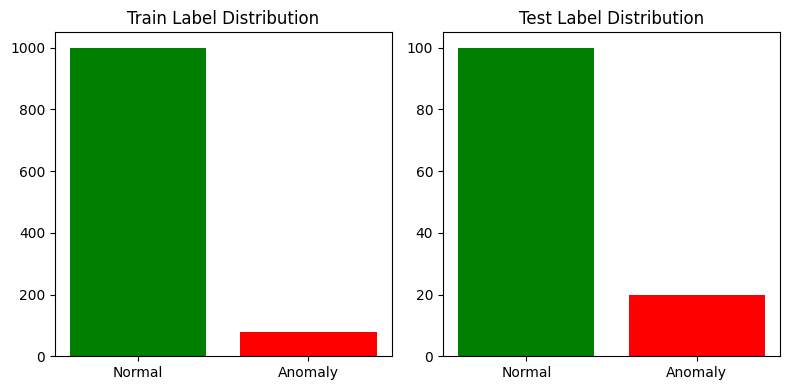

In [25]:
# 라벨 분포 시각화
import matplotlib.pyplot as plt

labels = ['Normal', 'Anomaly']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, np.bincount(y_train), color=['green', 'red'])
plt.title("Train Label Distribution")

plt.subplot(1, 2, 2)
plt.bar(labels, np.bincount(y_test), color=['green', 'red'])
plt.title("Test Label Distribution")

plt.tight_layout()
plt.show()


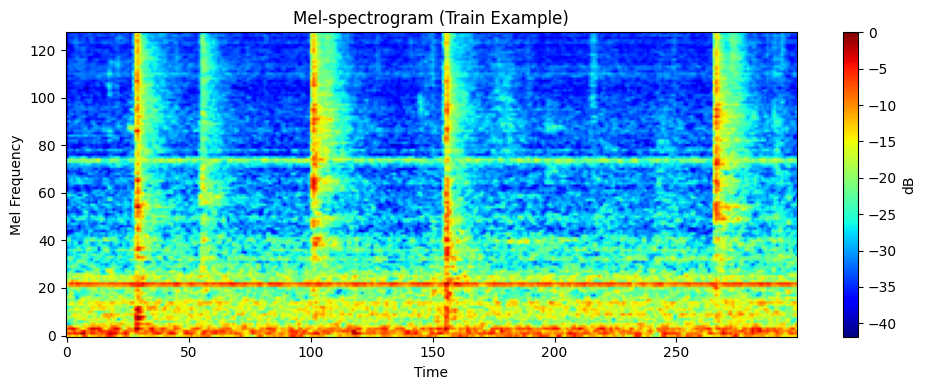

In [ ]:
# 멜스펙트로그램 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X_train[0][:, :, 0], origin='lower', aspect='auto', cmap='jet')
plt.colorbar(label='dB')
plt.title("Mel-spectrogram (Train Example)")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()

Epoch 1/30
27/27 [==============================] - 23s 754ms/step - loss: 0.2155 - accuracy: 0.9537 - val_loss: 0.6264 - val_accuracy: 0.8102
Epoch 2/30


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 20s 732ms/step - loss: 0.1952 - accuracy: 0.9549 - val_loss: 0.6322 - val_accuracy: 0.8102
Epoch 3/30
27/27 [==============================] - 21s 797ms/step - loss: 0.1917 - accuracy: 0.9549 - val_loss: 0.6119 - val_accuracy: 0.8102
Epoch 4/30
27/27 [==============================] - 20s 732ms/step - loss: 0.1879 - accuracy: 0.9549 - val_loss: 0.6427 - val_accuracy: 0.8102
Epoch 5/30
27/27 [==============================] - 20s 755ms/step - loss: 0.1883 - accuracy: 0.9549 - val_loss: 0.6403 - val_accuracy: 0.8102
Epoch 6/30
27/27 [==============================] - 20s 738ms/step - loss: 0.1882 - accuracy: 0.9549 - val_loss: 0.6196 - val_accuracy: 0.8102
Epoch 7/30
27/27 [==============================] - 20s 742ms/step - loss: 0.1932 - accuracy: 0.9549 - val_loss: 0.6216 - val_accuracy: 0.8102
Epoch 8/30
27/27 [==============================] - 20s 747ms/step - loss: 0.1960 - accuracy: 0.9549 - val_loss: 0.6072 - val_accuracy: 0.8102
Epoch 9/30

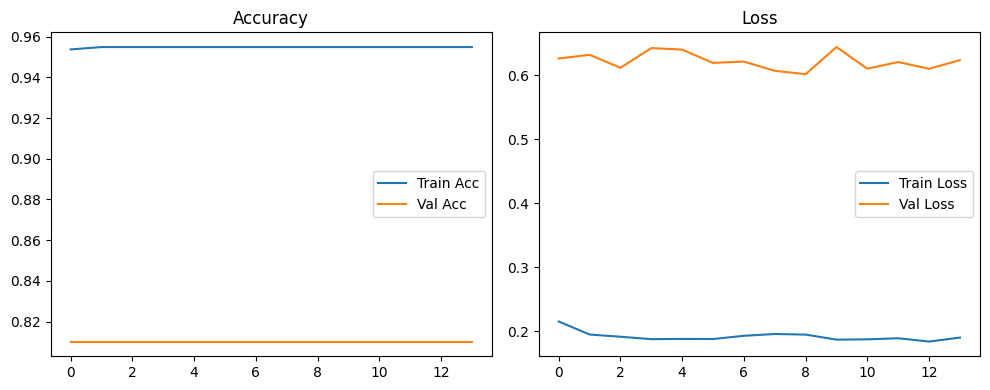

모델 저장 완료


In [27]:
# CNN_LSTM
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# 1. 모델 정의
def build_cnn_lstm_model(input_shape=(128, 300, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Reshape((-1, 128)))  # LSTM용 타임스텝 구조
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. 모델 생성
model = build_cnn_lstm_model(input_shape=(128, 300, 1))

# 3. 콜백 설정
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
checkpoint_path = "cnn_lstm_best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# 4. 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

# 5. 학습 히스토리 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.tight_layout()
plt.show()

# 6. 모델 저장 (선택: 최종 모델 전체 저장)
model.save("cnn_lstm_final_model.h5")
print("모델 저장 완료")


4/4 [==============================] - 1s 185ms/step


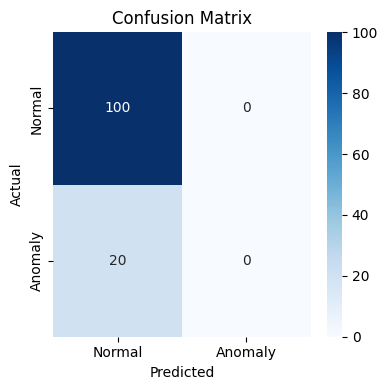

Classification Report
              precision    recall  f1-score   support

      Normal       0.83      1.00      0.91       100
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.83       120
   macro avg       0.42      0.50      0.45       120
weighted avg       0.69      0.83      0.76       120



c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


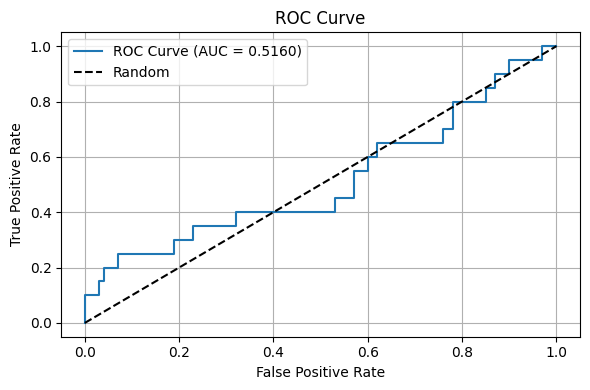

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 예측
y_pred_prob = model.predict(X_test)  # 확률 예측
y_pred = (y_pred_prob > 0.5).astype(int)  # 이진 예측

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 3. Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# 4. ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# 클래스 불균형 -> 이상 예측 못함
# 모델이 normal에만 과적합됨  -> 모델 다시 만들기(class_weight='balanced' 적용, 불량 클래스 증강, 최적 threshold적용해야함)



In [ ]:
import os
import numpy as np
import shutil

# 현재 데이터 폴더 (normal + anomaly가 모두 있음)
train_npy_dir = r'C:\Users\enjoy\Downloads\dev_bearing\bearing\train_npy'
aug_npy_dir = r'C:\Users\enjoy\Downloads\dev_bearing\bearing\train_npy_augmented'
os.makedirs(aug_npy_dir, exist_ok=True)

# 증강할 대상: 파일명에 'anomaly' 포함된 것만 선택
npy_files = [f for f in os.listdir(train_npy_dir) if 'anomaly' in f and f.endswith('.npy')]
copy_count = 5  # 1개당 5배 증강

for f in npy_files:
    src_path = os.path.join(train_npy_dir, f)
    for i in range(copy_count):
        new_name = f.replace('.npy', f'_copy{i}.npy')
        dst_path = os.path.join(aug_npy_dir, new_name)
        shutil.copy(src_path, dst_path)

In [33]:
# 증강된 파일을 train_npy로 이동
aug_files = os.listdir(aug_npy_dir)
for f in aug_files:
    shutil.move(os.path.join(aug_npy_dir, f), os.path.join(train_npy_dir, f))


In [ ]:
# npy 개수 파악
import os

# 경로 설정
npy_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'

# 모든 파일 가져오기
all_files = os.listdir(npy_dir)

# 정상 / 이상 구분
normal_files = [f for f in all_files if 'normal' in f]
anomaly_files = [f for f in all_files if 'anomaly' in f]

print(f" 정상 파일 수: {len(normal_files)}")
print(f" 이상(불량) 파일 수: {len(anomaly_files)}")

 정상 파일 수: 1000
 이상(불량) 파일 수: 480


In [39]:
import numpy as np
import os
from collections import Counter

# 경로 설정
train_npy_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'
test_npy_dir = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/test_npy'

# 파일 리스트 로딩
train_files = sorted([f for f in os.listdir(train_npy_dir) if f.endswith('.npy')])
test_files = sorted([f for f in os.listdir(test_npy_dir) if f.endswith('.npy')])

# 라벨 추출 함수: 파일명에서 normal / anomaly 여부 파악
def get_label(filename):
    return 0 if 'normal' in filename else 1

# 라벨 리스트 생성
y_train = [get_label(f) for f in train_files]
y_test = [get_label(f) for f in test_files]

# 분포 확인
print(" Train 라벨 분포:", Counter(y_train))
print(" Test 라벨 분포:", Counter(y_test))


 Train 라벨 분포: Counter({0: 1000, 1: 480})
 Test 라벨 분포: Counter({0: 100, 1: 20})


In [40]:
from sklearn.model_selection import train_test_split

# 예: X는 np.load한 결과, y는 위에서 만든 라벨 리스트
# 일단 shape 확인용 더미
X = np.array([np.load(os.path.join(train_npy_dir, f)) for f in train_files])
y = np.array(y_train)

# 분할
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True  # ← 여기 shuffle 꼭 True
)

# 분포 확인
print(" 훈련 라벨 분포:", Counter(y_train_split))
print(" 검증 라벨 분포:", Counter(y_val_split))


 훈련 라벨 분포: Counter({0: 800, 1: 384})
 검증 라벨 분포: Counter({0: 200, 1: 96})


In [ ]:
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# 데이터 로딩 함수
def load_data(npy_dir):
    X, y = [], []
    for fname in os.listdir(npy_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(npy_dir, fname)
        label = 0 if 'normal' in fname.lower() else 1
        arr = np.load(path)
        arr = arr[..., np.newaxis]  # shape: (128, T, 1)
        X.append(arr)
        y.append(label)
    return np.array(X), np.array(y)

# 데이터 로딩
npy_path = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'
X, y = load_data(npy_path)
print("전체 데이터 shape:", X.shape, y.shape)
print("라벨 분포:", Counter(y))

# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("훈련 라벨 분포:", Counter(y_train))
print("검증 라벨 분포:", Counter(y_val))

# class_weight 자동 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weight:", class_weights)

# CNN 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 313, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 설정
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_model.h5", save_best_only=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 학습 이력 저장
np.save('cnn_history.npy', history.history)


전체 데이터 shape: (1480, 128, 313, 1) (1480,)
라벨 분포: Counter({0: 1000, 1: 480})
훈련 라벨 분포: Counter({0: 800, 1: 384})
검증 라벨 분포: Counter({0: 200, 1: 96})
Class Weight: {0: 0.74, 1: 1.5416666666666667}
Epoch 1/30
37/37 [==============================] - 24s 625ms/step - loss: 3.3741 - accuracy: 0.5422 - val_loss: 0.6895 - val_accuracy: 0.6757
Epoch 2/30


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 23s 615ms/step - loss: 0.6932 - accuracy: 0.5938 - val_loss: 0.6926 - val_accuracy: 0.6723
Epoch 3/30
37/37 [==============================] - 23s 615ms/step - loss: 0.6932 - accuracy: 0.6782 - val_loss: 0.6924 - val_accuracy: 0.6757
Epoch 4/30
37/37 [==============================] - 23s 615ms/step - loss: 0.6932 - accuracy: 0.6444 - val_loss: 0.6920 - val_accuracy: 0.6757
Epoch 5/30
37/37 [==============================] - 25s 673ms/step - loss: 0.6932 - accuracy: 0.4358 - val_loss: 0.6933 - val_accuracy: 0.3243
Epoch 6/30
37/37 [==============================] - 26s 710ms/step - loss: 0.6930 - accuracy: 0.6292 - val_loss: 0.6925 - val_accuracy: 0.6655


10/10 [==============================] - 1s 120ms/step
Classification Report
              precision    recall  f1-score   support

      Normal       0.68      1.00      0.81       200
     Anomaly       0.00      0.00      0.00        96

    accuracy                           0.68       296
   macro avg       0.34      0.50      0.40       296
weighted avg       0.46      0.68      0.54       296

Confusion Matrix
[[200   0]
 [ 96   0]]


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


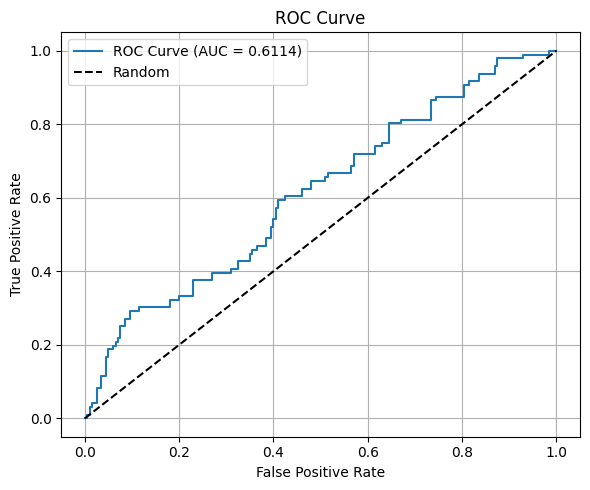

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 모델 예측 (확률)
y_pred_prob = model.predict(X_val)
# 이진 분류 확정값 (threshold=0.5 기준)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification Report & Confusion Matrix
print("Classification Report")
print(classification_report(y_val, y_pred, target_names=["Normal", "Anomaly"]))

print("Confusion Matrix")
print(confusion_matrix(y_val, y_pred))

# ROC Curve + AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
auc_score = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title( "ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import precision_recall_curve

# 확률 기반 예측
y_pred_prob = model.predict(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_prob)

# f1-score 최대인 threshold 선택
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)


10/10 [==============================] - 1s 120ms/step
Best Threshold: 0.49380678


In [46]:
# 확률 예측
y_pred_prob = model.predict(X_val)

# 최적 threshold 적용
y_pred = (y_pred_prob > 0.49380678).astype(int)


10/10 [==============================] - 1s 126ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Anomaly']))

auc_score = roc_auc_score(y_val, y_pred_prob)
print("AUC Score:", auc_score)
# CNN만으로는 시퀀스 정보 못잡는 한계

Confusion Matrix
[[ 25 175]
 [  4  92]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.86      0.12      0.22       200
     Anomaly       0.34      0.96      0.51        96

    accuracy                           0.40       296
   macro avg       0.60      0.54      0.36       296
weighted avg       0.69      0.40      0.31       296

AUC Score: 0.6114062499999999


In [48]:
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 데이터 로딩 함수
def load_data(npy_dir):
    X, y = [], []
    for fname in os.listdir(npy_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(npy_dir, fname)
        label = 0 if 'normal' in fname.lower() else 1
        arr = np.load(path)
        arr = arr[..., np.newaxis]  # (128, T, 1)
        X.append(arr)
        y.append(label)
    return np.array(X), np.array(y)

# 데이터 로딩
npy_path = r'C:/Users/enjoy/Downloads/dev_bearing/bearing/train_npy'
X, y = load_data(npy_path)
print("전체 데이터 shape:", X.shape, y.shape)
print("라벨 분포:", Counter(y))

# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("훈련 라벨 분포:", Counter(y_train))
print("검증 라벨 분포:", Counter(y_val))

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weight:", class_weights)


전체 데이터 shape: (1480, 128, 313, 1) (1480,)
라벨 분포: Counter({0: 1000, 1: 480})
훈련 라벨 분포: Counter({0: 800, 1: 384})
검증 라벨 분포: Counter({0: 200, 1: 96})
Class Weight: {0: 0.74, 1: 1.5416666666666667}


In [49]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((input_shape[1], input_shape[0]))(inputs)  # (313, 128)

    # Conv1D로 positional encoding 대체
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x)

    # Transformer Encoder
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(128, activation='relu')(x)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = build_transformer_model(input_shape=(128, 313, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 설정
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("transformer_model.h5", save_best_only=True)

# 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 학습 이력 저장
np.save('transformer_history.npy', history.history)
# 실패

Epoch 1/30
37/37 [==============================] - 9s 191ms/step - loss: 0.9532 - accuracy: 0.5186 - val_loss: 0.6306 - val_accuracy: 0.6757
Epoch 2/30


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 7s 181ms/step - loss: 0.7399 - accuracy: 0.5000 - val_loss: 0.7452 - val_accuracy: 0.3243
Epoch 3/30
37/37 [==============================] - 7s 189ms/step - loss: 0.7209 - accuracy: 0.5135 - val_loss: 0.7005 - val_accuracy: 0.3243
Epoch 4/30
37/37 [==============================] - 7s 182ms/step - loss: 0.7152 - accuracy: 0.4704 - val_loss: 0.6751 - val_accuracy: 0.6757
Epoch 5/30
37/37 [==============================] - 6s 175ms/step - loss: 0.7313 - accuracy: 0.4747 - val_loss: 0.6934 - val_accuracy: 0.3412
Epoch 6/30
37/37 [==============================] - 6s 175ms/step - loss: 0.7061 - accuracy: 0.5465 - val_loss: 0.6944 - val_accuracy: 0.3243


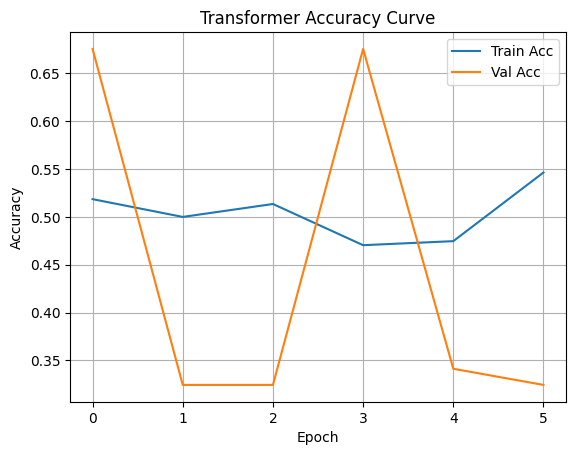

In [51]:
import matplotlib.pyplot as plt

hist = history.history
plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Transformer Accuracy Curve')
plt.show()


#################################################################################################

# 최종 모델

In [52]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed


In [ ]:
model = build_transformer_model(input_shape=(128, 313, 1))
# model - 와라라라라라라
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.25),  # focal loss 적용
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("transformer_focal_model.h5", save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  # 그대로 사용해도 무방함
    callbacks=[early_stop, checkpoint],
    verbose=1
)

np.save('transformer_focal_history.npy', history.history)


Epoch 1/30
37/37 [==============================] - 9s 188ms/step - loss: 0.1186 - accuracy: 0.5405 - val_loss: 0.0421 - val_accuracy: 0.6757
Epoch 2/30
37/37 [==============================] - 7s 186ms/step - loss: 0.0581 - accuracy: 0.5557 - val_loss: 0.0426 - val_accuracy: 0.6757
Epoch 3/30
37/37 [==============================] - 7s 196ms/step - loss: 0.0482 - accuracy: 0.6064 - val_loss: 0.0403 - val_accuracy: 0.6757
Epoch 4/30
37/37 [==============================] - 7s 188ms/step - loss: 0.0460 - accuracy: 0.5971 - val_loss: 0.0419 - val_accuracy: 0.6757
Epoch 5/30
37/37 [==============================] - 7s 192ms/step - loss: 0.0459 - accuracy: 0.6081 - val_loss: 0.0398 - val_accuracy: 0.6757
Epoch 6/30
37/37 [==============================] - 7s 194ms/step - loss: 0.0438 - accuracy: 0.6140 - val_loss: 0.0408 - val_accuracy: 0.6757
Epoch 7/30
37/37 [==============================] - 7s 188ms/step - loss: 0.0429 - accuracy: 0.6242 - val_loss: 0.0400 - val_accuracy: 0.6757
Epoch 

In [ ]:
from tensorflow.keras.models import load_model

# focal loss 함수 다시 정의 (load_model에 전달해야 함)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# 모델 불러오기 (loss 전달!)
model = load_model("transformer_focal_model.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})
##

In [55]:
# 콜백 다시 설정
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("transformer_focal_model_v2.h5", save_best_only=True)

# 추가 학습
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    initial_epoch=history.epoch[-1]+1,  # 이전 이어서
    epochs=history.epoch[-1]+21,        # +20 에포크
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 이력 저장 (기존 이력 + 추가 이력 이어붙이려면 원하시면 붙이는 코드도 제공 가능)
np.save('transformer_focal_history_v2.npy', history_finetune.history)


Epoch 31/50
37/37 [==============================] - 9s 196ms/step - loss: 0.0220 - accuracy: 0.8522 - val_loss: 0.0252 - val_accuracy: 0.8446
Epoch 32/50
37/37 [==============================] - 7s 191ms/step - loss: 0.0209 - accuracy: 0.8539 - val_loss: 0.0283 - val_accuracy: 0.7872
Epoch 33/50
37/37 [==============================] - 7s 190ms/step - loss: 0.0281 - accuracy: 0.7922 - val_loss: 0.0265 - val_accuracy: 0.7973
Epoch 34/50
37/37 [==============================] - 7s 178ms/step - loss: 0.0221 - accuracy: 0.8581 - val_loss: 0.0241 - val_accuracy: 0.8311
Epoch 35/50
37/37 [==============================] - 7s 183ms/step - loss: 0.0193 - accuracy: 0.8699 - val_loss: 0.0277 - val_accuracy: 0.8108
Epoch 36/50
37/37 [==============================] - 7s 191ms/step - loss: 0.0206 - accuracy: 0.8666 - val_loss: 0.0225 - val_accuracy: 0.8784
Epoch 37/50
37/37 [==============================] - 7s 194ms/step - loss: 0.0174 - accuracy: 0.9020 - val_loss: 0.0219 - val_accuracy: 0.8547

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 확률 예측
y_pred_proba = model.predict(X_val).ravel()

# ROC Curve 및 AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# 최적 threshold 계산 (Youden’s J statistic)
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]
print(f"Best Threshold: {best_threshold:.5f}  |  AUC: {roc_auc:.4f}")


10/10 [==============================] - 1s 62ms/step
Best Threshold: 0.35747  |  AUC: 0.9515


In [57]:
# 최적 threshold 기준 이진 예측
y_pred_binary = (y_pred_proba >= best_threshold).astype(int)

# Confusion Matrix & Report
cm = confusion_matrix(y_val, y_pred_binary)
cr = classification_report(y_val, y_pred_binary, target_names=["Normal", "Anomaly"])

print(" Confusion Matrix")
print(cm)
print("\n Classification Report")
print(cr)


 Confusion Matrix
[[167  33]
 [  0  96]]

 Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.91       200
     Anomaly       0.74      1.00      0.85        96

    accuracy                           0.89       296
   macro avg       0.87      0.92      0.88       296
weighted avg       0.92      0.89      0.89       296



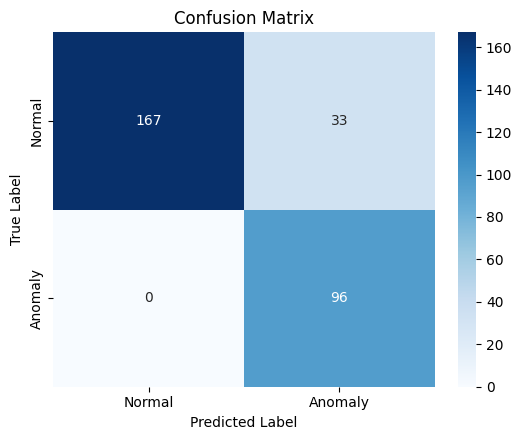

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
labels = ['Normal', 'Anomaly']

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


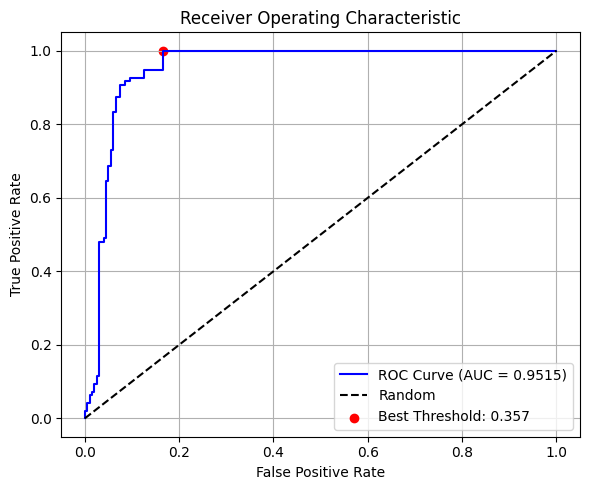

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)
best_threshold = thresholds[np.argmax(tpr - fpr)]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], color='red', label=f'Best Threshold: {best_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 두 개의 이력 불러오기
hist1 = np.load('transformer_focal_history.npy', allow_pickle=True).item()
hist2 = np.load('transformer_focal_history_v2.npy', allow_pickle=True).item()

# 키 기준 합치기
history = {}
for key in hist1:
    if key in hist2:
        history[key] = hist1[key] + hist2[key]  # 리스트 이어붙이기
    else:
        history[key] = hist1[key]

# 확인용 출력
print("합쳐진 metric 키:", history.keys())
print(f"총 Epoch 수: {len(history['accuracy'])}")

합쳐진 metric 키: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
총 Epoch 수: 50


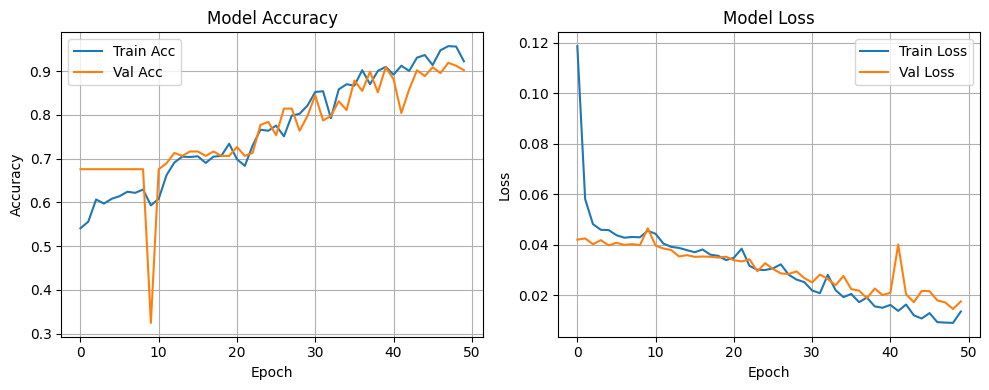

In [78]:
# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 모델 불러오기

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import numpy as np

# 1. focal loss 정의
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# 2. 모델 로드 (focal_loss 포함)
model = load_model(
    "transformer_focal_model_v2.h5",
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
)

# 3. 최적 threshold 값 (Youden's J 기준 사전 계산값)
best_threshold = 0.35747
